# Imports and datasets

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, classification_report
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

from collections import Counter
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb

In [ ]:
white_df = pd.read_csv('winequality-white.csv', sep=';')
red_df = pd.read_csv('winequality-red.csv', sep=';')

numerical = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
              'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
              'pH', 'sulphates', 'alcohol']

categorical = []

regr_pred_feat = 'quality'
classif_pred_feat = 'is_high_quality'

sns.set_theme()
seed = 10

# Intro analysis

We can create two subplots to analyze and compare white and red wine quality distribution.

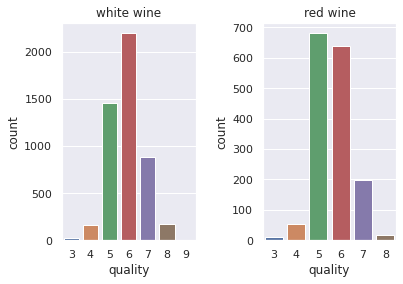

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.5)
ax1.set_title("white wine")
ax2.set_title("red wine")
sns.countplot(x='quality', data=white_df, order=sorted(white_df['quality'].unique()), ax=ax1)
sns.countplot(x='quality', data=red_df, order=sorted(red_df['quality'].unique()), ax=ax2)
fig.show()

Now that we see how quality is distributed, let's look at and analyze statistics summary of all variables.

In [ ]:
white_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [ ]:
red_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Lets create another column, where we will represent alcohol content as low, mid or high instead of continuous values. We will use mean and standard deviation, because alcohol values are normally distributed.

In [ ]:
def discretize(data):
  """
    Converts pandas Series array containing continuous values into 
    three categories based on mean and standard deviation.

    >>> discretise(pd.Series([1.1, 4, 7, 5]))
    ['low', 'mid', 'high', 'mid']
  """
  result = []

  for i in data:
    if i < data.mean() - data.std():
      result.append('low')
    elif i > data.mean() + data.std():
      result.append('high')
    else:
      result.append('mid')

  return result

In [ ]:
white_df['alcohol_cat'] = discretize(white_df['alcohol'])
red_df['alcohol_cat'] = discretize(red_df['alcohol'])

categorical.append('alcohol_cat')

We can then visualize the quality of wine based on its alcohol content category.

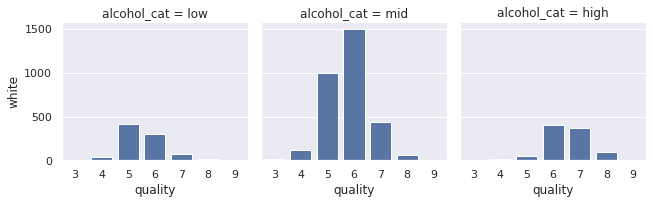

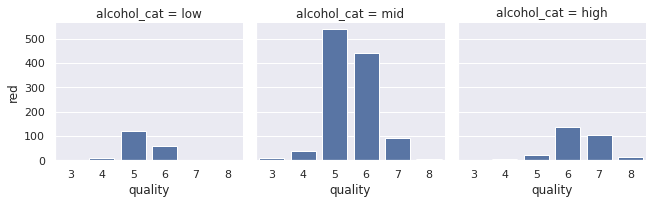

In [ ]:
for wine_df, wine_name in zip([white_df, red_df], ['white', 'red']):
  g = sns.FacetGrid(wine_df, col="alcohol_cat", col_order=['low', 'mid', 'high'])
  g.map(sns.countplot, 'quality', order=sorted(wine_df['quality'].unique()))
  g.set_ylabels(wine_name)

By looking at the illustrations, we can draw conclusion that high alcohol content indicates that the wine is more likely to be higher quality. The same trend applies for both white and red wine. Now, lets try to analyse if the amount of sugar has any correlation with the quality of wine.

We will define a function which will discretize given data into two classes. As we have seen in the statistics summaries, residual sugar variable in both dataframes has some outliers. <br><br> For example, white wine residual sugar:
*   25th percentile value is 1.7
*   75th percentile value is 9.9
*   max value is 65.8

and red wine residual sugar:
*   25th percentile value is 1.9
*   75th percentile value is 2.6
*   max value is 15.5

<br> We can clearly see that max values are far from the majority of values. Therefore, we will use median to discretise data, because mean could be artificially high considering impact of those outliers.

In [ ]:
def discretize_binary(data, threshold=None):
  """
    Convert pandas Series array containing continuous values into 
    two categories based on median. If the optional argument threshold
    is passed, then the data is discretised using given threshold instead of median.

    >>> discretise_binary(pd.Series([1, 6, 2.4, 11, 7.1]))
    ['no', 'yes', 'no', 'yes', 'yes']

    >>> discretise_binary(pd.Series([1, 6, 2.4, 11, 7.1]), threshold=7)
    ['no', 'no', 'no', 'yes', 'yes']
  """
  result = []

  for i in data:

    if threshold != None:
      if i < threshold:
        result.append('no')
      else:
        result.append('yes')
    
    else:
      if i < data.median():
        result.append('no')
      else:
        result.append('yes')

  return result

Now, lets use our newly defined function to seperate wine into sweet and dry using residual sugar variable and store the result into a new variable called is_sweet. We will also use the same function with an optional argument threshold to discretize quality into two categories low and high for machine learning classification models.

In [ ]:
white_df['is_sweet'] = discretize_binary(white_df['residual sugar'])
red_df['is_sweet'] = discretize_binary(red_df['residual sugar'])

categorical.append('is_sweet')

Note that using inappropriate threshold for discretizing quality can lead to class imbalance problem, where the minority class is harder to predict, because the model's learning process is focused on the majority class. We will use Counter to select the best threshold splitting the quality as even as possible.

In [ ]:
thresholds = [5, 6, 7]

for wine_df, wine_name in zip([white_df, red_df], ['white', 'red']):
  for threshold in thresholds:
    counter = Counter(discretize_binary(wine_df[regr_pred_feat], threshold))
    counter_diff = abs(counter['no'] - counter['yes'])
    print(f'{wine_name}, threshold {threshold}, count difference between classes {counter_diff}')

white, threshold 5, count difference between classes 4532
white, threshold 6, count difference between classes 1618
white, threshold 7, count difference between classes 2778
red, threshold 5, count difference between classes 1473
red, threshold 6, count difference between classes 111
red, threshold 7, count difference between classes 1165


This indicates that the most suitable threshold is 6.

In [ ]:
white_df[classif_pred_feat] = discretize_binary(white_df[regr_pred_feat], 6)
red_df[classif_pred_feat] = discretize_binary(red_df[regr_pred_feat], 6)

Plotting the quality distribution based on sweetness:

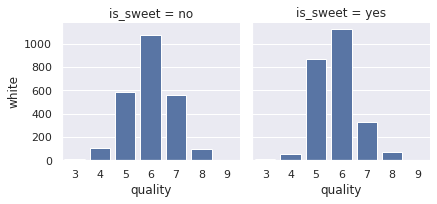

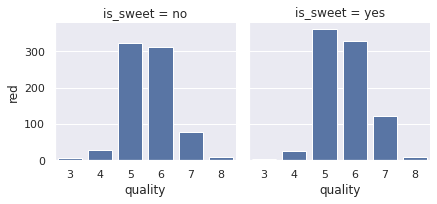

In [ ]:
for wine_df, wine_name in zip([white_df, red_df], ['white', 'red']):
  g = sns.FacetGrid(wine_df, col="is_sweet", col_order=['no', 'yes'])
  g.map(sns.countplot, 'quality', order=sorted(wine_df['quality'].unique()))
  g.set_ylabels(wine_name)

Seems that sweet white wine is perceived lower quality than dry wine. On the other hand, red wine sweetness has little to no correlation with the quality.

Now, let's look at the quality with respect to both alcohol content category and sweetness category.

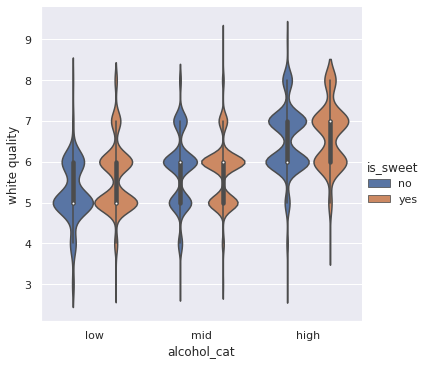

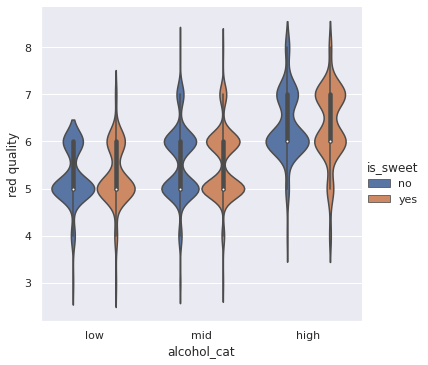

In [ ]:
for wine_df, wine_name in zip([white_df, red_df], ['white quality', 'red quality']):
    g = sns.catplot(x='alcohol_cat', y='quality', data=wine_df, kind='violin', hue='is_sweet',
                    order=['low', 'mid', 'high'], hue_order=['no', 'yes'])
    g.set_ylabels(wine_name)

We can also try to look at quality distribution based on alcohol and sweetness on the combined white and red wine dataframe.

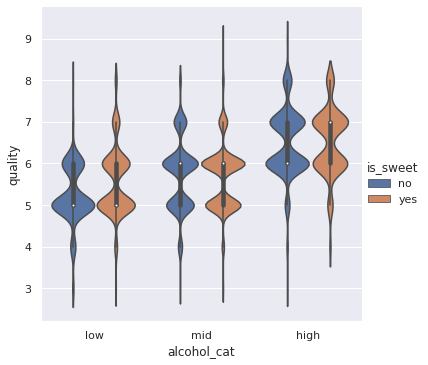

In [ ]:
combined_df = pd.concat([white_df, red_df], ignore_index=True)

g = sns.catplot(x='alcohol_cat', y='quality', data=combined_df, kind='violin', hue='is_sweet',
                    order=['low', 'mid', 'high'], hue_order=['no', 'yes'])

Combined dataframe shows the same trends. It is clearly visible in both illustrations that higher alcohol content indices higher quality, although no significant differences are seen between sweet and non sweet wines.

# White Wine

## Extended Analysis

Lets check the distribution of each variable's values across the dataset.

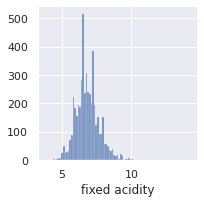

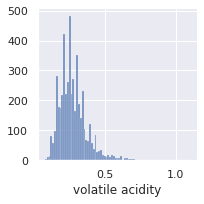

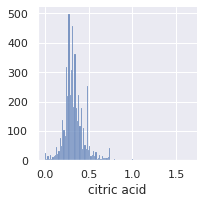

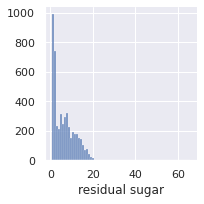

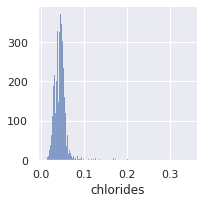

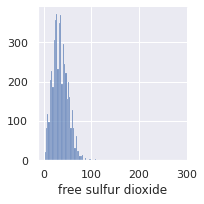

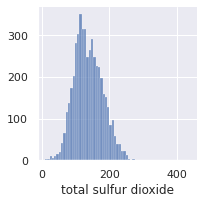

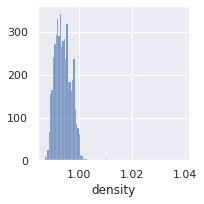

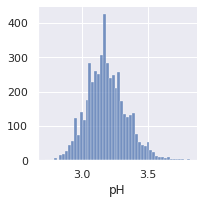

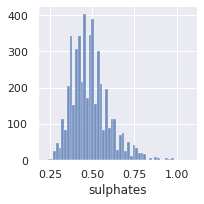

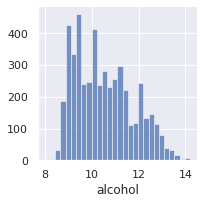

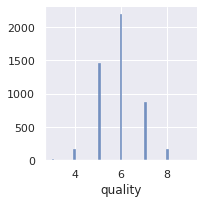

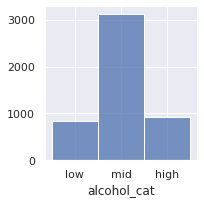

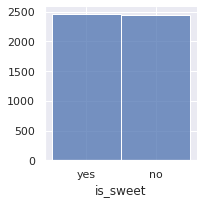

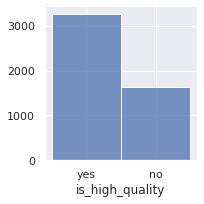

In [ ]:
for column in white_df.columns:
    g = sns.FacetGrid(white_df)
    g.map(sns.histplot, column)

All the variables except **residual sugar** are more or less normally distributed. Our output variable **quality** also looks normally distributed, but it consists only of integers and quality of 7 is considered better than quality of 6, therefore it can also be perceived as rank. 

The reason I am mentioning this, is that the way we look at our output will define which measures we will use to compare their correlation.

Let's treat quality both as a rank and as a continuous value. Therefore we will use both Spearman's rank and Pearson correlation coefficients to find out how quality correlates with each feature.

In [ ]:
white_df.corr(method='spearman').quality

fixed acidity          -0.084485
volatile acidity       -0.196562
citric acid             0.018333
residual sugar         -0.082070
chlorides              -0.314488
free sulfur dioxide     0.023713
total sulfur dioxide   -0.196680
density                -0.348351
pH                      0.109362
sulphates               0.033319
alcohol                 0.440369
quality                 1.000000
Name: quality, dtype: float64

Note that Pearson correlation coefficient is the default one for `corr()` function.

In [ ]:
white_df.corr().quality

fixed acidity          -0.113663
volatile acidity       -0.194723
citric acid            -0.009209
residual sugar         -0.097577
chlorides              -0.209934
free sulfur dioxide     0.008158
total sulfur dioxide   -0.174737
density                -0.307123
pH                      0.099427
sulphates               0.053678
alcohol                 0.435575
quality                 1.000000
Name: quality, dtype: float64

In [ ]:
white_df.corr(method='kendall').quality

fixed acidity          -0.065474
volatile acidity       -0.154787
citric acid             0.014557
residual sugar         -0.063087
chlorides              -0.244856
free sulfur dioxide     0.017164
total sulfur dioxide   -0.151230
density                -0.266598
pH                      0.084441
sulphates               0.026403
alcohol                 0.346672
quality                 1.000000
Name: quality, dtype: float64

We can see that white wine quality has the highest positive correlation with alcohol content, which confirms our previuosly drawn assumptions, and the highest negative correlation with density.

Machine learning model that uses two variables that are highly correlated with each other is redundant, therefore we can visualize and analyze correlations between each pair of variables to find useful information. We will now use Pearson correlation coefficient method, which is the default one for `.corr()` function, to measure linear correlation between our features.

Text(0.5, 1.0, 'White Wine')

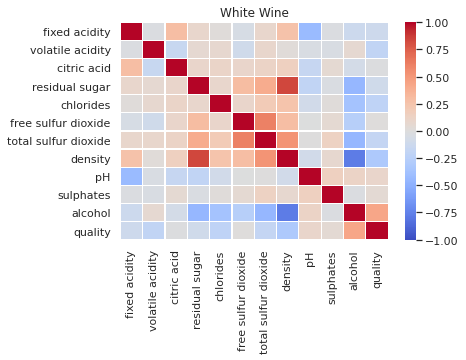

In [ ]:
white_corr_mat = white_df.corr()

# visualize using heatmap
sns.heatmap(white_corr_mat, vmin=-1, vmax=1, center=0, linewidths=0.2, cmap='coolwarm').set_title("White Wine")

Heatmap indicates that density has a very high positive correlation with residual sugar and a very high negative correlation with alcohol content. Besides that, we can also see quite high correlation between free sulfur dioxide and total sulfur dioxide. Let's look at the numbers.

In [ ]:
white_corr_mat

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.022697,0.289181,0.089021,0.023086,-0.049396,0.091070,0.265331,-0.425858,-0.017143,-0.120881,-0.113663
volatile acidity,-0.022697,1.000000,-0.149472,0.064286,0.070512,-0.097012,0.089261,0.027114,-0.031915,-0.035728,0.067718,-0.194723
citric acid,0.289181,-0.149472,1.000000,0.094212,0.114364,0.094077,0.121131,0.149503,-0.163748,0.062331,-0.075729,-0.009209
residual sugar,0.089021,0.064286,0.094212,1.000000,0.088685,0.299098,0.401439,0.838966,-0.194133,-0.026664,-0.450631,-0.097577
chlorides,0.023086,0.070512,0.114364,0.088685,1.000000,0.101392,0.198910,0.257211,-0.090439,0.016763,-0.360189,-0.209934
free sulfur dioxide,-0.049396,-0.097012,0.094077,0.299098,0.101392,1.000000,0.615501,0.294210,-0.000618,0.059217,-0.250104,0.008158
total sulfur dioxide,0.091070,0.089261,0.121131,0.401439,0.198910,0.615501,1.000000,0.529881,0.002321,0.134562,-0.448892,-0.174737
density,0.265331,0.027114,0.149503,0.838966,0.257211,0.294210,0.529881,1.000000,-0.093591,0.074493,-0.780138,-0.307123
pH,-0.425858,-0.031915,-0.163748,-0.194133,-0.090439,-0.000618,0.002321,-0.093591,1.000000,0.155951,0.121432,0.099427
sulphates,-0.017143,-0.035728,0.062331,-0.026664,0.016763,0.059217,0.134562,0.074493,0.155951,1.000000,-0.017433,0.053678


Some correlations that we are currently interested in:


*   density and alcohol ~ `-0.78`
*   density and residual sugar ~ `0.84`
*   free sulfur dioxide and total sulfur dioxide ~ `0.62`

Let's see if we can find some logic here. Firstly, we can take a second look at density's statistics summary.


In [ ]:
white_df['density'].describe()

count    4898.000000
mean        0.994027
std         0.002991
min         0.987110
25%         0.991723
50%         0.993740
75%         0.996100
max         1.038980
Name: density, dtype: float64

Average white wine density is about 1 gram per cubic centimeter, similar to water. Alcohol and sugar densities are about 0.79 and 1.59 gram per cubic centimeter, respectively. As we put more alcohol into wine, its density decreases towards that 0.79 gram per cubic centimeter. The same logic applies to sugar. Now the high negative correlation between density and alcohol and high positive correlation between density and residual sugar make more sense. But is that a good thing or a bad thing?

Given alcohol content and residual sugar we could approximate density by ourselves, which means that density basically gives us no new valuable information. Besides, density has a very low variance (i.e. standard deviation `0.002991` squared), which makes it even less useful.

Now, let's look at sulfur dioxide. As far as I understand, total sulfur dioxide is free sulfur dioxide plus the sulfur dioxide that is bound to other chemicals in the wine. If all the values of free sulfur dioxide are less than total sulfur dioxide, it suggests that our assumption is probably correct.

In [ ]:
(white_df['total sulfur dioxide'] - white_df['free sulfur dioxide']).min()

4.0

As we can see the minimum value of total sulfur dioxide and free sulfur dioxide difference is still positive. The fact that one is probably just a portion of the other explains the high positive correlation. I do not know how either of those impact the quality of the wine, but the logic suggests using only one of those would remove some redundancy, although we will have to experiment with both.

Now, we have an idea of some useful and some not so useful features, but let's see if we can find some additional valuable information from statistics summary.

In [ ]:
white_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


pH proportionally to its values has quite low variance, which indicates that pH might not be useful for predicting quality. However, some internet sources suggest that wine pH is typically between 3 and 4, which is almost the same as in our datasets, thus we cannot cross out pH yet.

Another thing we could try to find relationship between quality and all the features is Mutual Information. It is a measurement which tells how knowledge of one quantity reduces the uncertainty of our target variable. Mutual information can detect any kind of relationship, not like correlation (e.g. Pearson's correlation coefficient), which only measures linear relationship. This will be helpful as it is suited for categorical variables as well. We will use two functions (Originally created by Ryan Holbrook, Kaggle Feature Engineering Course) that we will modify for both regression and classification. We will be able to use these function for red wine as well.

In [ ]:
def regr_mi_scores(X, y, discrete_features):
  mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
  mi_scores = pd.Series(mi_scores, index=X.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores

def classif_mi_scores(X, y, discrete_features):
  mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
  mi_scores = pd.Series(mi_scores, index=X.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores

First, we will factorize data (i.e. convert categorical data strings to integers). Factorization is also required for machine learning. First, we will store alcohol_cat column into pandas Categorical object so that it preserves the order of low < mid < high when factorized. 

In [ ]:
white_df['alcohol_cat'] = pd.Categorical(white_df['alcohol_cat'], categories=['low', 'mid', 'high'], 
                                       ordered=True)
white_df['alcohol_cat'], _ = pd.factorize(white_df['alcohol_cat'], sort=True)

# remaining columns
for column in white_df.select_dtypes('object'):
  white_df[column], _ = pd.factorize(white_df[column])

X_mi = white_df.loc[:, numerical + categorical]
y_mi_regr = white_df[regr_pred_feat]
y_mi_classif = white_df[classif_pred_feat]

discrete_features = white_df.dtypes == int
discrete_features = discrete_features.drop([regr_pred_feat, classif_pred_feat])

In [ ]:
regr_mi_scores(X_mi, y_mi_regr, discrete_features)

density                 0.186310
alcohol                 0.161468
residual sugar          0.094192
total sulfur dioxide    0.087346
alcohol_cat             0.083013
chlorides               0.082981
free sulfur dioxide     0.062877
volatile acidity        0.059775
citric acid             0.048932
sulphates               0.036682
is_sweet                0.022540
pH                      0.019332
fixed acidity           0.016147
dtype: float64

In [ ]:
classif_mi_scores(X_mi, y_mi_classif, discrete_features)

alcohol                 0.098694
density                 0.086476
alcohol_cat             0.069980
chlorides               0.045672
total sulfur dioxide    0.039600
volatile acidity        0.035892
citric acid             0.035845
residual sugar          0.032206
free sulfur dioxide     0.031895
sulphates               0.013593
fixed acidity           0.013118
pH                      0.011014
is_sweet                0.000000
dtype: float64

## Machine Learning Preparation

Let's think about what we've learned throughout analysis and pick features that might be the most suitable for our model. First, we can look at all the features we have.

In [ ]:
features = numerical + categorical
features

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'alcohol_cat',
 'is_sweet']

We've found out that density is redundant for our model, thus we will remove it. Then we'll have to look at the analysis again and remove some features and try to find out which ones works best.

In [ ]:
to_remove = ['alcohol_cat', 'is_sweet', 'density', 'sulphates', 'chlorides', 'residual sugar', 'citric acid']
for feature in to_remove:
  features.remove(feature)

In [ ]:
X = white_df[features]

## Machine Learning - Regression

Let's store quality to y for regression.

In [ ]:
y = white_df[regr_pred_feat]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

Normalize the data:

In [ ]:
# Train data
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

# Test data
X_test -= mean
X_test /= std

Note that the quantities used for normalizing the test data are computed using the training data. We don't want to use in our workflow any quantity computed on the test data, even for something as simple as data normalization.

### Linear Regression

Let's create a Linear Regression model, fit it to the train data and evaluate it on test data.

In [ ]:
model = LinearRegression().fit(X_train, y_train)

print(f'Cross validation score: {cross_val_score(model, X_train, y_train).mean()}')

y_pred = model.predict(X_test)

print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')

Cross validation score: 0.2477256311555672
Mean absolute error: 0.5891761277245617


This means that on average our predictions on test set are off by ~ `0.59`, which doesn't look too bad, but considering our values range from 3 to 9, it is not ideal.

### Support Vector Regression

Let's try Support Vector Regression.

In [ ]:
model = SVR().fit(X_train, y_train)

print(f'Cross validation score: {cross_val_score(model, X_train, y_train).mean()}')

y_pred = model.predict(X_test)

print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')

Cross validation score: 0.3457582609665141
Mean absolute error: 0.5279197259865616


Support Vector Regression predictions are off by ~ `0.53`, which seems better than Linear Regression, but still could be improved.

### Random Forest Regression

Let's try a more sophisticated model Random Forest Regressor. 

In [ ]:
model = RandomForestRegressor().fit(X_train, y_train)

print(f'Cross validation score: {cross_val_score(model, X_train, y_train).mean()}')

y_pred = model.predict(X_test)

print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')

Cross validation score: 0.45699407050734236
Mean absolute error: 0.4292142857142857


Random Forest Regression provides even a better result than support vector regression ~ `0.43`. Don't forget that our predicted values have numbers after the decimal point and our y_test values are integers only, thus it would be nearly impossible to get error with a value very close to 0. If the model predicts quality of 6.9, we kind of imagine that it wanted to predict a value of 7. What if we approach the predictions in a slightly different way? In a way that the model gave the highest probability that the integer 7 is the quality of this data point, because 7 is the closest integer to the prediction of 6.9. Let's try calculating mean absolute error using rounded values.

In [ ]:
print(f'Mean absolute error using rounded predictions: {mean_absolute_error(y_test, y_pred.round())}')

Mean absolute error using rounded predictions: 0.3622448979591837


With this kind of approach we achieved a better result.

## Machine Learning - Classification

Let's store is_high_quality to y for classification.

In [ ]:
y = white_df[classif_pred_feat]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

Normalize the data:

In [ ]:
# Train data
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

# Test data
X_test -= mean
X_test /= std

### Logistic Regression

Logistic Regression is a statistical model that uses logistic function to model a binary dependent variable (i.e. our target values `y`), therefore it can be used for binary classification problems.

In [ ]:
clf = LogisticRegression()

clf.fit(X_train, y_train)

# predictions on training set
y_pred_train = clf.predict(X_train)

# predictions on test set
y_pred_test = clf.predict(X_test)

print('Train Set Predictions Report:\n')
print(classification_report(y_train, y_pred_train))
print('Test Set Predictions Report:\n')
print(classification_report(y_test, y_pred_test))

scores = cross_val_score(clf, X_train, y_train, cv=5)
print(f"Cross-validation scores: {scores.mean():.2f} (± {scores.std() * 2:.2f})")

Train Set Predictions Report:

              precision    recall  f1-score   support

           0       0.76      0.86      0.81      2589
           1       0.64      0.49      0.55      1329

    accuracy                           0.73      3918
   macro avg       0.70      0.67      0.68      3918
weighted avg       0.72      0.73      0.72      3918

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.77      0.85      0.81       669
           1       0.59      0.47      0.52       311

    accuracy                           0.73       980
   macro avg       0.68      0.66      0.67       980
weighted avg       0.72      0.73      0.72       980

Cross-validation scores: 0.73 (± 0.02)


### SVC

In [ ]:
clf = SVC()
clf.fit(X_train, y_train)

# predictions on training set
y_pred_train = clf.predict(X_train)

# predictions on test set
y_pred_test = clf.predict(X_test)

print('Train Set Predictions Report:\n')
print(classification_report(y_train, y_pred_train))
print('Test Set Predictions Report:\n')
print(classification_report(y_test, y_pred_test))

scores = cross_val_score(clf, X_train, y_train)
print(f"Cross-validation scores: {scores.mean():.2f} (± {scores.std() * 2:.2f})")

Train Set Predictions Report:

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      2589
           1       0.72      0.61      0.66      1329

    accuracy                           0.79      3918
   macro avg       0.77      0.74      0.75      3918
weighted avg       0.78      0.79      0.78      3918

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       669
           1       0.69      0.56      0.61       311

    accuracy                           0.78       980
   macro avg       0.75      0.72      0.73       980
weighted avg       0.77      0.78      0.77       980

Cross-validation scores: 0.77 (± 0.02)


In [ ]:
tuned_parameters = [{'kernel': ['rbf'], 'C': [1, 10, 100]},
                    {'kernel': ['poly'], 'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

clf = GridSearchCV(SVC(), tuned_parameters)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:\n")
print(clf.best_params_)
print("\nGrid scores on development set:\n")

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print(f"{mean:.3f} (± {std * 2:.03f}) for {params}")

Best parameters set found on development set:

{'C': 100, 'kernel': 'rbf'}

Grid scores on development set:

0.768 (± 0.019) for {'C': 1, 'kernel': 'rbf'}
0.771 (± 0.028) for {'C': 10, 'kernel': 'rbf'}
0.772 (± 0.028) for {'C': 100, 'kernel': 'rbf'}
0.715 (± 0.027) for {'C': 1, 'kernel': 'poly'}
0.721 (± 0.017) for {'C': 10, 'kernel': 'poly'}
0.723 (± 0.019) for {'C': 100, 'kernel': 'poly'}
0.737 (± 0.024) for {'C': 1, 'kernel': 'linear'}
0.737 (± 0.023) for {'C': 10, 'kernel': 'linear'}
0.737 (± 0.023) for {'C': 100, 'kernel': 'linear'}


### Random Forest

In [ ]:
clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=seed)
clf.fit(X_train, y_train)

# predictions on training set
y_pred_train = clf.predict(X_train)

# predictions on test set
y_pred_test = clf.predict(X_test)

print('Train Set Predictions Report:\n')
print(classification_report(y_train, y_pred_train))
print('Test Set Predictions Report:\n')
print(classification_report(y_test, y_pred_test))

scores = cross_val_score(clf, X_train, y_train)
print(f"Cross-validation scores: {scores.mean():.2f} (± {scores.std() * 2:.2f})")

Train Set Predictions Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2589
           1       1.00      1.00      1.00      1329

    accuracy                           1.00      3918
   macro avg       1.00      1.00      1.00      3918
weighted avg       1.00      1.00      1.00      3918

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       669
           1       0.80      0.74      0.77       311

    accuracy                           0.86       980
   macro avg       0.84      0.82      0.83       980
weighted avg       0.86      0.86      0.86       980

Cross-validation scores: 0.81 (± 0.03)


Let's search for the most optimal hyperparameters.

In [ ]:
tuned_parameters = [{'n_estimators': [20, 50, 150, 300],
                    'max_depth': [20, 30, 40, 50]}]

clf = GridSearchCV(RandomForestClassifier(), tuned_parameters)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:\n")
print(clf.best_params_)
print("\nGrid scores on development set:\n")

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print(f"{mean:.3f} (± {std * 2:.03f}) for {params}")

Best parameters set found on development set:

{'max_depth': 30, 'n_estimators': 300}

Grid scores on development set:

0.809 (± 0.039) for {'max_depth': 20, 'n_estimators': 20}
0.812 (± 0.026) for {'max_depth': 20, 'n_estimators': 50}
0.814 (± 0.027) for {'max_depth': 20, 'n_estimators': 150}
0.816 (± 0.031) for {'max_depth': 20, 'n_estimators': 300}
0.807 (± 0.026) for {'max_depth': 30, 'n_estimators': 20}
0.810 (± 0.028) for {'max_depth': 30, 'n_estimators': 50}
0.808 (± 0.033) for {'max_depth': 30, 'n_estimators': 150}
0.817 (± 0.026) for {'max_depth': 30, 'n_estimators': 300}
0.812 (± 0.029) for {'max_depth': 40, 'n_estimators': 20}
0.814 (± 0.024) for {'max_depth': 40, 'n_estimators': 50}
0.815 (± 0.029) for {'max_depth': 40, 'n_estimators': 150}
0.815 (± 0.037) for {'max_depth': 40, 'n_estimators': 300}
0.807 (± 0.028) for {'max_depth': 50, 'n_estimators': 20}
0.812 (± 0.035) for {'max_depth': 50, 'n_estimators': 50}
0.813 (± 0.029) for {'max_depth': 50, 'n_estimators': 150}
0.8

### XGBoost

In [ ]:
clf = xgb.XGBClassifier(max_depth=50, n_estimators=100, random_state=seed)
clf.fit(X_train, y_train)

# predictions on training set
y_pred_train = clf.predict(X_train)

# predictions on test set
y_pred_test = clf.predict(X_test)

print('Train Set Predictions Report:\n')
print(classification_report(y_train, y_pred_train))
print('Test Set Predictions Report:\n')
print(classification_report(y_test, y_pred_test))

scores = cross_val_score(clf, X_train, y_train)
print(f"Cross-validation scores: {scores.mean():.2f} (± {scores.std() * 2:.2f})")

Train Set Predictions Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2589
           1       1.00      1.00      1.00      1329

    accuracy                           1.00      3918
   macro avg       1.00      1.00      1.00      3918
weighted avg       1.00      1.00      1.00      3918

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       669
           1       0.78      0.72      0.75       311

    accuracy                           0.84       980
   macro avg       0.83      0.81      0.82       980
weighted avg       0.84      0.84      0.84       980

Cross-validation scores: 0.81 (± 0.02)


In [ ]:
tuned_parameters = [{'n_estimators': [100, 200, 300],
                    'max_depth': [30, 50, 70],
                     'eta': [0.1, 0.3]}]

clf = GridSearchCV(xgb.XGBClassifier(), tuned_parameters)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:\n")
print(clf.best_params_)
print("\nGrid scores on development set:\n")

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print(f"{mean:.3f} (± {std * 2:.03f}) for {params}")

Best parameters set found on development set:

{'eta': 0.1, 'max_depth': 50, 'n_estimators': 100}

Grid scores on development set:

0.806 (± 0.027) for {'eta': 0.1, 'max_depth': 30, 'n_estimators': 100}
0.805 (± 0.029) for {'eta': 0.1, 'max_depth': 30, 'n_estimators': 200}
0.804 (± 0.029) for {'eta': 0.1, 'max_depth': 30, 'n_estimators': 300}
0.809 (± 0.023) for {'eta': 0.1, 'max_depth': 50, 'n_estimators': 100}
0.803 (± 0.028) for {'eta': 0.1, 'max_depth': 50, 'n_estimators': 200}
0.803 (± 0.032) for {'eta': 0.1, 'max_depth': 50, 'n_estimators': 300}
0.809 (± 0.023) for {'eta': 0.1, 'max_depth': 70, 'n_estimators': 100}
0.803 (± 0.028) for {'eta': 0.1, 'max_depth': 70, 'n_estimators': 200}
0.803 (± 0.032) for {'eta': 0.1, 'max_depth': 70, 'n_estimators': 300}
0.806 (± 0.027) for {'eta': 0.3, 'max_depth': 30, 'n_estimators': 100}
0.805 (± 0.029) for {'eta': 0.3, 'max_depth': 30, 'n_estimators': 200}
0.804 (± 0.029) for {'eta': 0.3, 'max_depth': 30, 'n_estimators': 300}
0.809 (± 0.023) 

# Red Wine

## Extended Analysis

Lets do the similar analysis for red wine as well.

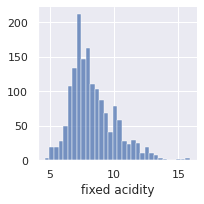

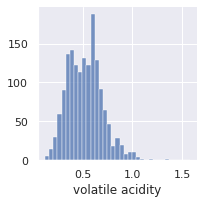

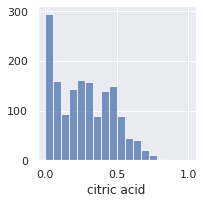

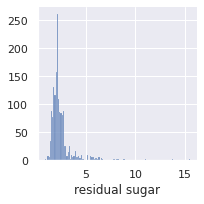

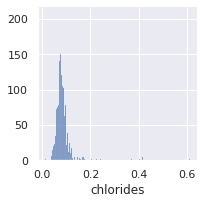

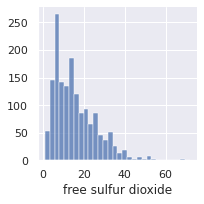

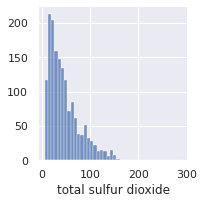

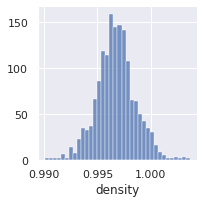

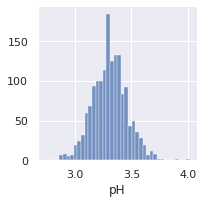

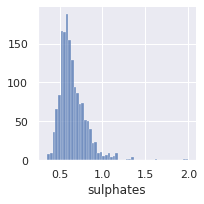

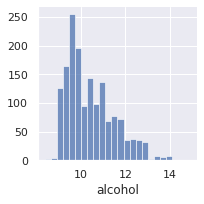

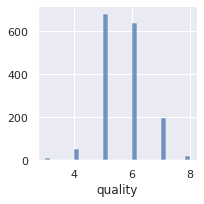

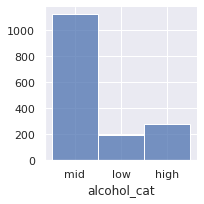

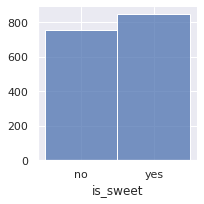

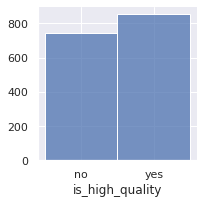

In [ ]:
for column in red_df.columns:
    g = sns.FacetGrid(red_df)
    g.map(sns.histplot, column)

We'll try both Spearman's rank and Pearson correlation coefficients for the same reason - quality can be perceived as both continuous values and rank.

In [ ]:
red_df.corr(method='spearman').quality

fixed acidity           0.114084
volatile acidity       -0.380647
citric acid             0.213481
residual sugar          0.032048
chlorides              -0.189922
free sulfur dioxide    -0.056901
total sulfur dioxide   -0.196735
density                -0.177074
pH                     -0.043672
sulphates               0.377060
alcohol                 0.478532
quality                 1.000000
Name: quality, dtype: float64

In [ ]:
red_df.corr().quality

fixed acidity           0.124052
volatile acidity       -0.390558
citric acid             0.226373
residual sugar          0.013732
chlorides              -0.128907
free sulfur dioxide    -0.050656
total sulfur dioxide   -0.185100
density                -0.174919
pH                     -0.057731
sulphates               0.251397
alcohol                 0.476166
quality                 1.000000
Name: quality, dtype: float64

Again, highest positive correlation with alcohol, but for red wine quality the highest negative correlation is with volatile acidity. Let's look how each feature correlates with each other.

Text(0.5, 1.0, 'Red Wine')

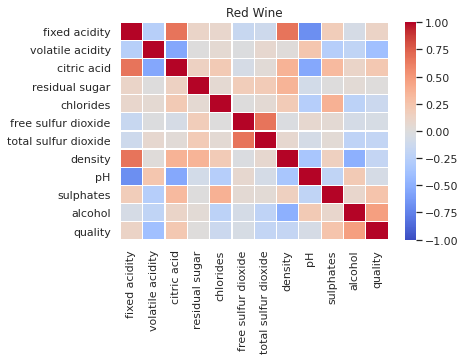

In [ ]:
red_corr_mat = red_df.corr()

sns.heatmap(red_corr_mat, vmin=-1, vmax=1, center=0, linewidths=0.2, cmap='coolwarm').set_title("Red Wine")

Total sulfur dioxide has a very high correlation with free sulfur dioxide, the explanation is the same as it was with white wine. We can also see that pH has a high negative correlation with fixed acidity, citric acid a high positive with fixed acidity and citric acid a high negative correlation with volatile acidity. Let's check the numbers.

In [ ]:
red_corr_mat

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


Some correlations that we are currently interested in:


*   citric acid and fixed acidity ~ `0.66`
*   citric acid and volatile acidity ~ `-0.61`
*   pH and fixed acidity ~ `-0.71`



Several fixed acids originating in grapes are found in wine. Some of these are tartaric, malic, citric. It means that citric acid is part of wine's fixed acidity, which explains `0.66` correlation between those two. Volatile acidity is the other group of total acids found in wine, thus correlation `-0.61` between citric acid and volatile acidity is not so obvious and does not give us a good idea of what to do with them. Although, ~ `-0.28` correlation between fixed and volatile acidity indicates that wine makers might balance those two types of acids to achieve total acidity less than some certain limit. What all of this tells us?

Citric acid being part of fixed acidity means that predicting quality using both of these might introduce some redundancy. We'll have to consider training model using only one of them, but right now we cannot be sure which one - we do not know how fixed acids other than citric impact the quality of wine. (Correlation coefficients indicate that citric acid has more effect on quality than fixed acidity, but we will experiment with that later.)

What about pH and fixed acidity `-0.71` correlation? Research suggests that acids' ability to dissociate affects pH, but there is no direct relationship between their concentration in wine.

Let's see if we can find any valuable information looking at the statistics of features.

In [ ]:
red_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,alcohol_cat,is_sweet,is_high_quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023,1.053784,0.529706,0.534709
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569,0.541965,0.499273,0.498950
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000,0.000000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000,1.000000,0.000000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000,1.000000,1.000000,1.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000,1.000000,1.000000,1.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,2.000000,1.000000,1.000000


Not much more than we already know. Let's see what information will Mutual Information provide us. 

In [ ]:
# encode categorical data to int
red_df['alcohol_cat'] = pd.Categorical(red_df['alcohol_cat'], categories=['low', 'mid', 'high'], 
                                       ordered=True)
red_df['alcohol_cat'], _ = pd.factorize(red_df['alcohol_cat'], sort=True)

# remaining columns
for column in red_df.select_dtypes('object'):
  red_df[column], _ = pd.factorize(red_df[column])

X_mi = red_df.loc[:, numerical + categorical]
y_mi_regr = red_df[regr_pred_feat]
y_mi_classif = red_df[classif_pred_feat]

discrete_features = red_df.dtypes == int
discrete_features = discrete_features.drop([regr_pred_feat, classif_pred_feat])

In [ ]:
regr_mi_scores(X_mi, y_mi_regr, discrete_features)

alcohol                 0.161491
alcohol_cat             0.107784
sulphates               0.103854
volatile acidity        0.098259
total sulfur dioxide    0.088720
citric acid             0.071180
fixed acidity           0.070416
density                 0.070118
pH                      0.028930
free sulfur dioxide     0.012264
chlorides               0.010668
is_sweet                0.002430
residual sugar          0.000000
dtype: float64

In [ ]:
classif_mi_scores(X_mi, y_mi_classif, discrete_features)

alcohol                 0.125308
alcohol_cat             0.094099
sulphates               0.082718
density                 0.062595
total sulfur dioxide    0.060962
volatile acidity        0.054206
chlorides               0.031436
free sulfur dioxide     0.019780
citric acid             0.019688
residual sugar          0.018899
fixed acidity           0.011071
pH                      0.000120
is_sweet                0.000000
dtype: float64

## Machine Learning Preparation

Let's think about what we've learned throughout analysis and pick features that might be the most suitable for our model. First, we can look at all the features we have.

In [ ]:
features = numerical + categorical
features

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'alcohol_cat',
 'is_sweet']

As we've previously discussed variable density is redundant. We've also talked about choosing one of free sulfur dioxide and total sulfur dioxide and different correlation coefficients suggest that total sulfur dioxide has a bigger impact on quality, so we are going to use that one first, but we have to experiment with both. The same with citric acid and fixed acidity, analysis indicated that citric acid is the better choice, we are going to start with that. Categorical features alcohol_cat and is_sweet helped us to visualize the relationships, but Mutual Information method suggested that alcohol is the better choice than alcohol_cat for both regression and classification and residual sugar is the better choice than is_sweet for classification, but worse for regression. We are going to start with continuous values of alcohol and sugar.

In [ ]:
# First
#to_remove = ['density', 'free sulfur dioxide', 'fixed acidity', 'alcohol_cat', 'is_sweet']
to_remove = ['alcohol_cat', 'is_sweet', 'density', 'fixed acidity', 'free sulfur dioxide']
for feature in to_remove:
  features.remove(feature)

Just as we did with the white wine, we will store features that will help us to predict the quality in `X` and store the quality itself in `y`. We will also split the data into train and test sets, so that our model will have some data to train on and we will evaluate the model on test data. This ensures that the model is evaluated on a never seen data, which is the main rule of building a robust model.

In [ ]:
X = red_df[features]

## Machine Learning - Regression

We will store the output feature to y for regression.

In [ ]:
y = red_df[regr_pred_feat]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

Normalize the data:

In [ ]:
# Train data
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

# Test data
X_test -= mean
X_test /= std

### Linear Regression

Let's create a Linear Regression model, fit it to the train data and evaluate it on test data.

In [ ]:
model = LinearRegression().fit(X_train, y_train)

print(f'Cross validation score: {cross_val_score(model, X_train, y_train).mean()}')

y_pred = model.predict(X_test)

print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')

Cross validation score: 0.3322719686601334
Mean absolute error: 0.5322391991797837


This means that on average our predictions are off by ~ `0.53`.

### Support Vector Regression

Let's try Support Vector Regression.

In [ ]:
model = SVR().fit(X_train, y_train)

print(f'Cross validation score: {cross_val_score(model, X_train, y_train).mean()}')

y_pred = model.predict(X_test)

print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')

Cross validation score: 0.3634583676505323
Mean absolute error: 0.4812799582878545


Support Vector Regression predictions are off by ~ `0.48`, which seems better than Linear Regression by quite a margin.

### Random Forest Regression

Let's try a more sophisticated model Random Forest Regressor. 

In [ ]:
model = RandomForestRegressor().fit(X_train, y_train)

print(f'Cross validation score: {cross_val_score(model, X_train, y_train).mean()}')

y_pred = model.predict(X_test)

print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')

Cross validation score: 0.4452735130858261
Mean absolute error: 0.453625


Random Forest Regressor predictions are off by ~ `0.45`, which is even better than Support Vector Regression. Let's see what results rounded values produce.

In [ ]:
print(f'Mean absolute error using rounded predictions: {mean_absolute_error(y_test, y_pred.round())}')

Mean absolute error using rounded predictions: 0.378125


## Machine Learning - Classification

We will store the output feature to y for classification.

In [ ]:
y = red_df[classif_pred_feat]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

Normalize the data:

In [ ]:
# Train data
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

# Test data
X_test -= mean
X_test /= std

### Logistic Regression

In [ ]:
model = LogisticRegression(random_state=seed)

model.fit(X_train, y_train)

# predictions on training set
y_pred_train = model.predict(X_train)

# predictions on test set
y_pred_test = model.predict(X_test)

print('Train Set Predictions Report:\n')
print(classification_report(y_train, y_pred_train))
print('Test Set Predictions Report:\n')
print(classification_report(y_test, y_pred_test))

scores = cross_val_score(model, X_train, y_train)
print(f"Cross-validation scores: {scores.mean():.2f} (± {scores.std() * 2:.2f})")

Train Set Predictions Report:

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       601
           1       0.76      0.76      0.76       678

    accuracy                           0.75      1279
   macro avg       0.75      0.75      0.75      1279
weighted avg       0.75      0.75      0.75      1279

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.69      0.73      0.71       143
           1       0.77      0.73      0.75       177

    accuracy                           0.73       320
   macro avg       0.73      0.73      0.73       320
weighted avg       0.73      0.73      0.73       320

Cross-validation scores: 0.75 (± 0.03)


### SVC

In [ ]:
model = SVC(random_state=seed)

model.fit(X_train, y_train)

# predictions on training set
y_pred_train = model.predict(X_train)

# predictions on test set
y_pred_test = model.predict(X_test)

print('Train Set Predictions Report:\n')
print(classification_report(y_train, y_pred_train))
print('Test Set Predictions Report:\n')
print(classification_report(y_test, y_pred_test))

scores = cross_val_score(model, X_train, y_train)
print(f"Cross-validation scores: {scores.mean():.2f} (± {scores.std() * 2:.2f})")

Train Set Predictions Report:

              precision    recall  f1-score   support

           0       0.78      0.79      0.78       601
           1       0.81      0.80      0.81       678

    accuracy                           0.79      1279
   macro avg       0.79      0.79      0.79      1279
weighted avg       0.79      0.79      0.79      1279

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.72      0.71      0.72       143
           1       0.77      0.77      0.77       177

    accuracy                           0.75       320
   macro avg       0.74      0.74      0.74       320
weighted avg       0.75      0.75      0.75       320

Cross-validation scores: 0.76 (± 0.06)


### Random Forest

In [ ]:
model = RandomForestClassifier(random_state=seed, max_depth=30, n_estimators=300)

model.fit(X_train, y_train)

# predictions on training set
y_pred_train = model.predict(X_train)

# predictions on test set
y_pred_test = model.predict(X_test)

print('Train Set Predictions Report:\n')
print(classification_report(y_train, y_pred_train))
print('Test Set Predictions Report:\n')
print(classification_report(y_test, y_pred_test))

scores = cross_val_score(model, X_train, y_train)
print(f"Cross-validation scores: {scores.mean():.2f} (± {scores.std() * 2:.2f})")

Train Set Predictions Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       601
           1       1.00      1.00      1.00       678

    accuracy                           1.00      1279
   macro avg       1.00      1.00      1.00      1279
weighted avg       1.00      1.00      1.00      1279

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       143
           1       0.83      0.84      0.83       177

    accuracy                           0.82       320
   macro avg       0.81      0.81      0.81       320
weighted avg       0.82      0.82      0.82       320

Cross-validation scores: 0.81 (± 0.03)


In [ ]:
tuned_parameters = [{'n_estimators': [50, 100, 200, 300],
                    'max_depth': [10, 20, 30, 40, 50]}]

model = GridSearchCV(RandomForestClassifier(random_state=seed), tuned_parameters)
model.fit(X_train, y_train)

print("Best parameters set found on development set:\n")
print(model.best_params_)
print("\nGrid scores on development set:\n")

means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model.cv_results_['params']):
    print(f"{mean:.3f} (± {std * 2:.03f}) for {params}")

Best parameters set found on development set:

{'max_depth': 30, 'n_estimators': 50}

Grid scores on development set:

0.809 (± 0.029) for {'max_depth': 10, 'n_estimators': 50}
0.807 (± 0.028) for {'max_depth': 10, 'n_estimators': 100}
0.808 (± 0.041) for {'max_depth': 10, 'n_estimators': 200}
0.805 (± 0.035) for {'max_depth': 10, 'n_estimators': 300}
0.813 (± 0.052) for {'max_depth': 20, 'n_estimators': 50}
0.810 (± 0.049) for {'max_depth': 20, 'n_estimators': 100}
0.808 (± 0.036) for {'max_depth': 20, 'n_estimators': 200}
0.808 (± 0.035) for {'max_depth': 20, 'n_estimators': 300}
0.815 (± 0.052) for {'max_depth': 30, 'n_estimators': 50}
0.812 (± 0.037) for {'max_depth': 30, 'n_estimators': 100}
0.808 (± 0.036) for {'max_depth': 30, 'n_estimators': 200}
0.810 (± 0.034) for {'max_depth': 30, 'n_estimators': 300}
0.815 (± 0.052) for {'max_depth': 40, 'n_estimators': 50}
0.812 (± 0.037) for {'max_depth': 40, 'n_estimators': 100}
0.808 (± 0.036) for {'max_depth': 40, 'n_estimators': 200}


### XGBoost

In [ ]:
model = xgb.XGBClassifier(random_state=seed, max_depth=30, n_estimators=300)
model.fit(X_train, y_train)

# predictions on training set
y_pred_train = model.predict(X_train)

# predictions on test set
y_pred_test = model.predict(X_test)

print('Train Set Predictions Report:\n')
print(classification_report(y_train, y_pred_train))
print('Test Set Predictions Report:\n')
print(classification_report(y_test, y_pred_test))

scores = cross_val_score(model, X_train, y_train)
print(f"Cross-validation scores: {scores.mean():.2f} (± {scores.std() * 2:.2f})")

Train Set Predictions Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       601
           1       1.00      1.00      1.00       678

    accuracy                           1.00      1279
   macro avg       1.00      1.00      1.00      1279
weighted avg       1.00      1.00      1.00      1279

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.82      0.78      0.80       143
           1       0.83      0.86      0.84       177

    accuracy                           0.82       320
   macro avg       0.82      0.82      0.82       320
weighted avg       0.82      0.82      0.82       320

Cross-validation scores: 0.80 (± 0.03)


In [ ]:
tuned_parameters = [{'n_estimators': [50, 80, 100, 200, 300],
                    'max_depth': [20, 30, 40, 50]}]

model = GridSearchCV(xgb.XGBClassifier(random_state=seed), tuned_parameters)
model.fit(X_train, y_train)

print("Best parameters set found on development set:\n")
print(model.best_params_)
print("\nGrid scores on development set:\n")

means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model.cv_results_['params']):
    print(f"{mean:.3f} (± {std * 2:.03f}) for {params}")

Best parameters set found on development set:

{'max_depth': 20, 'n_estimators': 50}

Grid scores on development set:

0.803 (± 0.034) for {'max_depth': 20, 'n_estimators': 50}
0.803 (± 0.040) for {'max_depth': 20, 'n_estimators': 80}
0.799 (± 0.029) for {'max_depth': 20, 'n_estimators': 100}
0.801 (± 0.029) for {'max_depth': 20, 'n_estimators': 200}
0.801 (± 0.022) for {'max_depth': 20, 'n_estimators': 300}
0.803 (± 0.034) for {'max_depth': 30, 'n_estimators': 50}
0.801 (± 0.037) for {'max_depth': 30, 'n_estimators': 80}
0.802 (± 0.035) for {'max_depth': 30, 'n_estimators': 100}
0.801 (± 0.029) for {'max_depth': 30, 'n_estimators': 200}
0.802 (± 0.025) for {'max_depth': 30, 'n_estimators': 300}
0.803 (± 0.034) for {'max_depth': 40, 'n_estimators': 50}
0.801 (± 0.037) for {'max_depth': 40, 'n_estimators': 80}
0.802 (± 0.035) for {'max_depth': 40, 'n_estimators': 100}
0.801 (± 0.029) for {'max_depth': 40, 'n_estimators': 200}
0.802 (± 0.025) for {'max_depth': 40, 'n_estimators': 300}
0.